# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice I'd train this classifier, then export it for use in an application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

In [2]:
# Imports 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). 
The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but I'll resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define  transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
testset = datasets.ImageFolder(test_dir, transform=test_transforms)
validset = datasets.ImageFolder(valid_dir, transform=test_transforms)

# Using the image datasets and the transforms to define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False, num_workers=8)

### Label mapping

I'll load in a mapping from category label to category name. It's a JSON object that i'll read in with [`json` module](https://docs.python.org/2/library/json.html). This will give a dictionary mapping the integer encoded categories to the actual names of the flowers. I'll use this later.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I'll use one of the pretrained models from `torchvision.models` to get the image features. I will then build and train a new feed-forward classifier using those features.

I will:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training i'll be updating only the weights of the feed-forward network. 

In [5]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

In [6]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Turn off gradients, freeze parameters
for param in model.parameters():
    param.requires_grad = False
output_size = len(cat_to_name)
# Define new classifier
classifier = nn.Sequential(nn.Linear(2048, 576),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(576, 102),
                           nn.LogSoftmax(dim=1))
model.fc = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

epochs = 7
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move input and label tensors to Accelerator - MPS
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0
        # turn off gradients for validation set
        with torch.no_grad():

            # set model to evaluation mode
            model.eval()

            for images, labels in validloader:
                # Move input and label tensors to Accelerator - MPS
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # calculate accuracy
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += equals.type(torch.FloatTensor).mean()

            # set model back to train mode
            model.train()

        train_loss = running_loss / len(trainloader)
        test_loss = test_loss / len(validloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e + 1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Validation Loss: {:.3f}.. ".format(test_loss),
              "Model Accuracy: {:.3f}".format(accuracy / len(validloader)))


Epoch: 1/7..  Training Loss: 2.196..  Validation Loss: 0.661..  Model Accuracy: 0.837
Epoch: 2/7..  Training Loss: 0.816..  Validation Loss: 0.395..  Model Accuracy: 0.903
Epoch: 3/7..  Training Loss: 0.615..  Validation Loss: 0.308..  Model Accuracy: 0.914
Epoch: 4/7..  Training Loss: 0.524..  Validation Loss: 0.295..  Model Accuracy: 0.924
Epoch: 5/7..  Training Loss: 0.480..  Validation Loss: 0.265..  Model Accuracy: 0.927
Epoch: 6/7..  Training Loss: 0.442..  Validation Loss: 0.279..  Model Accuracy: 0.919
Epoch: 7/7..  Training Loss: 0.415..  Validation Loss: 0.284..  Model Accuracy: 0.925


## Testing the network

It's good practice to test trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. I'll run the test images through the network and measure the accuracy, the same way I did validation. 

In [7]:
# Do validation on the test set
with torch.no_grad():
    # set model to evaluation mode
    model.eval()

    test_loss = 0
    accuracy = 0
    total = 0

    for images, labels in testloader:
        # Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # calculate accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += equals.type(torch.FloatTensor).sum().item()
        total += labels.size(0)

    # set model back to train mode
    model.train()

    train_loss = running_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("Accuracy: {:.3f}%".format((accuracy / total) * 100))

Accuracy: 92.308%


## Save the checkpoint

Now that the network is trained, i'll save the model so it can be loaded later for making predictions. 
I want to completely rebuild the model later so I can use it for inference. I'll include any information I need in the checkpoint. 

In [8]:
# Save the checkpoint 
model.class_to_idx = trainset.class_to_idx
torch.save(model.state_dict(), 'checkpoint.pth')

checkpoint = {'input_size': 2048,
              'output_size': 102,
              'hidden_layers': [576],
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx,
              'optimizer_state': optimizer.state_dict(),
              'epochs': epochs}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [9]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    """
    Loads a checkpoint and rebuilds the model, optimizer, and criterion
    
    Parameters:
        filepath (str): file path to the checkpoint file
        
    Returns:
        model (torch.nn.Module): the loaded and rebuilt model
    """
    # Load the checkpoint
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))

    # Rebuild the model
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    classifier = nn.Sequential(nn.Linear(2048, 576),
                               nn.ReLU(),
                               nn.Dropout(p=0.2),
                               nn.Linear(576, 102),
                               nn.LogSoftmax(dim=1))
    model.fc = classifier
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])

    # Rebuild the optimizer
    optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # Rebuild the criterion
    criterion = nn.NLLLoss()

    # Return the model
    return model

model = load_checkpoint('checkpoint.pth')

# Inference for classification

Now i'll write a function to use a trained network for inference. That is, I'll be able to pass an image into the network and predict the class of the flower in the image. I'd write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 

I'll handle processing the input image first such that it can be used in the network. 

## Image Preprocessing

I'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training. 

First, i'll resize the images where the shortest side is 256 pixels, keeping the aspect ratio. Then i'll crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array, that i'd get from a PIL image.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. 

In [10]:
def process_image(image_path):
    """ Scales, crops, and normalizes a PyTorch tensor image for a
        PyTorch model, returns a Numpy array
    """
    # Define the transformations for the input image
    with Image.open(image_path) as im:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Apply the transformations to the input image
        image = transform(im)

    return image

The function below converts a PyTorch tensor and displays it in the notebook. Running the `process_image` function output through this function would return the original image (except for the cropped out portions).

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch's tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

## Class Prediction

It's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor i'll use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I will convert from these indices to the actual class labels using `class_to_idx` which I added to the model or from an `ImageFolder` I used to load the data ([see here](#Save-the-checkpoint)). I'd invert the dictionary so I can get a mapping from index to class as well.

Again, this method will take a path to an image and a model checkpoint, then return the probabilities and classes.

In [12]:
def predict(image_path, model, topk=5):
    """ Predict the class (or classes) of an image using a trained deep learning model.
    """
    model.eval()
    model.cpu()
    # Implement the code to predict the class from an image file
    image = process_image(image_path)
    image = image.unsqueeze(0)
    # Calculate the class probabilities (softmax) for image
    with torch.no_grad():
        output = model.forward(image)
        top_p, top_class = torch.topk(output, topk)
        top_p = top_p.to('cpu')
        top_class = top_class.to('cpu')
        top_p = top_p.exp()
        class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
        mapped_classes = list()

    for label in top_class.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])
    np.set_printoptions(suppress=True, formatter={'float_kind': '{:f}'.format})

    return top_p.numpy()[0], mapped_classes


predict('flowers/test/1/image_06743.jpg', model)
    

(array([0.999949, 0.000023, 0.000016, 0.000004, 0.000003], dtype=float32),
 ['1', '83', '86', '89', '53'])

## Sanity Checking

Now that the trained model can be used for predictions, I'll check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 
I will now convert from the class integer encoding to actual flower names with the `cat_to_name.json` file I loaded earlier in the notebook. To show a PyTorch tensor as an image, i'll use the `imshow` function defined above.

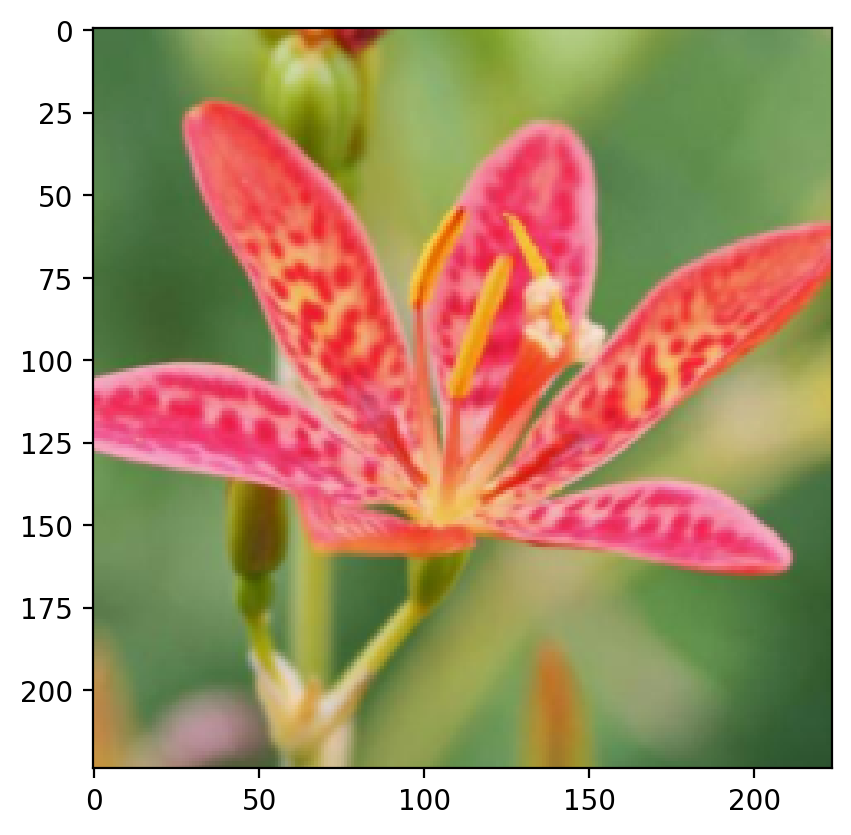

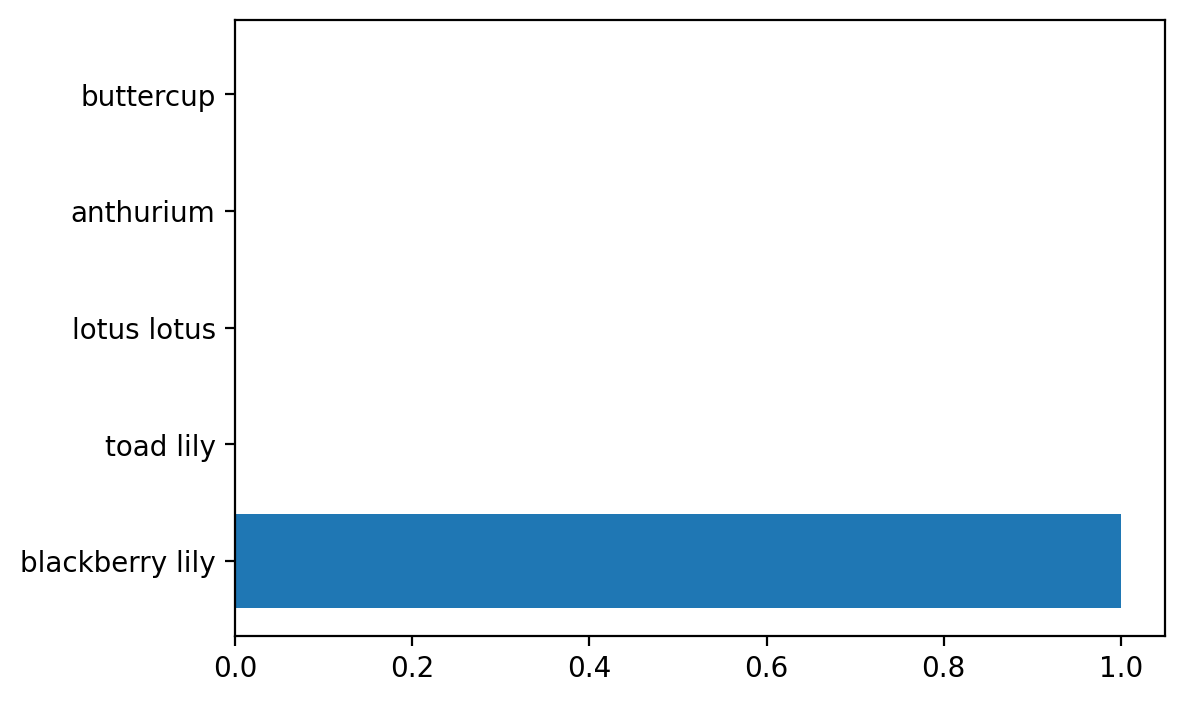

In [13]:
# Display an image along with the top 5 classes
image_pth = 'flowers/test/102/image_08015.jpg'
imshow(process_image(image_pth))
probs, classes = predict(image_pth, model)
names = [cat_to_name[c] for c in classes] 

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(names, probs);